In [1]:
'''in this version we always use the same image (times batch size), substract batch average at each step to obtain batch-wise advantages'''

'in this version we always use the same image (times batch size), substract batch average at each step to obtain batch-wise advantages'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


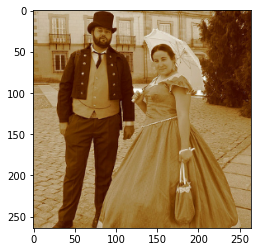

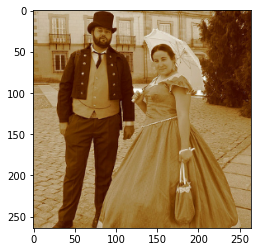

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -12.001205444335938
action means and variances at step -10: [-0.20259354  0.17896543] [1.13497354 1.09735694]
action means and variances at step -5: [-0.27250261 -0.12797576] [1.00744147 0.84225859]
action statmeans and variances at step -10: [0.00341301 0.02409143] [1. 1.]
action statmeans and variances at step -5: [0.00186591 0.01679203] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -11.554027557373047
action means and variances at step -10: [ 0.02941928 -0.05401246] [0.79596384 1.2737503 ]
action means and variances at step -5: [-0.12382833 -0.00245677] [1.26935531 1.2717191 ]
action statmeans and variances at step -10: [-0.09851    -0.05117625] [1. 1.]
action statmeans and variances at step -5: [-0.09722197 -0.04786533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -11.705642700195312
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -11.81007194519043
action means and variances at step -10: [-0.28230245 -0.11804668] [0.90938605 0.56214166]
action means and variances at step -5: [ 0.24648075 -0.24946268] [0.69734289 0.93496251]
action statmeans and variances at step -10: [ 0.02610267 -0.09136769] [1. 1.]
action statmeans and variances at step -5: [ 0.02031431 -0.08832841] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -11.45382308959961
action means and variances at step -10: [-0.09582491 -0.154101  ] [0.89305357 0.8837563 ]
action means and variances at step -5: [-0.22455702 -0.14128   ] [0.95611113 1.18756971]
action statmeans and variances at step -10: [-0.07489043 -0.1042079 ] [1. 1.]
action statmeans and variances at step -5: [-0.08791563 -0.11600874] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -12.194952964782715
action means and variance

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -11.498546600341797
action means and variances at step -10: [-0.41590717  0.24618119] [0.63359863 1.35811454]
action means and variances at step -5: [-0.1112475   0.13676182] [0.95860691 0.62105475]
action statmeans and variances at step -10: [-0.1477313  -0.01696982] [1. 1.]
action statmeans and variances at step -5: [-0.16087739 -0.02314009] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -11.87792682647705
action means and variances at step -10: [-0.21114845 -0.25031036] [1.18625145 1.19762198]
action means and variances at step -5: [-0.01143949  0.07220979] [0.84534642 0.69970123]
action statmeans and variances at step -10: [-0.11966978  0.02364812] [1. 1.]
action statmeans and variances at step -5: [-0.11588782  0.02665922] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -11.683701515197754
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -11.245928764343262
action means and variances at step -10: [-0.18563006  0.36148639] [0.94421411 0.57223551]
action means and variances at step -5: [-0.34085219  0.04824168] [0.78764368 0.9734609 ]
action statmeans and variances at step -10: [-0.3531195   0.09848659] [1. 1.]
action statmeans and variances at step -5: [-0.34895438  0.11112653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -11.349356651306152
action means and variances at step -10: [-0.17659002 -0.08958091] [1.42028429 0.83241423]
action means and variances at step -5: [-0.5089922   0.01114418] [1.48810283 1.05275357]
action statmeans and variances at step -10: [-0.38623017  0.12872963] [1. 1.]
action statmeans and variances at step -5: [-0.38669398  0.11337398] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -11.310844421386719
action means and varian

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -11.33997631072998
action means and variances at step -10: [-0.36914252  0.17479918] [0.59877505 0.86098504]
action means and variances at step -5: [-0.20970388  0.06896997] [0.99354505 1.02014008]
action statmeans and variances at step -10: [-0.16716966  0.02823222] [1. 1.]
action statmeans and variances at step -5: [-0.1681937   0.04340861] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -11.870290756225586
action means and variances at step -10: [-0.01155578  0.00446989] [0.56322316 0.92279892]
action means and variances at step -5: [0.01323731 0.1258213 ] [0.97902811 0.75391552]
action statmeans and variances at step -10: [-0.2651171  -0.01561883] [1. 1.]
action statmeans and variances at step -5: [-0.25838602  0.00116104] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -11.70860481262207
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -11.664497375488281
action means and variances at step -10: [-0.30247653  0.08547733] [0.68769421 1.47056685]
action means and variances at step -5: [-0.44861422 -0.05278836] [0.56286306 1.52163697]
action statmeans and variances at step -10: [-0.24131562 -0.012615  ] [1. 1.]
action statmeans and variances at step -5: [-0.21995683  0.02178213] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -11.877604484558105
action means and variances at step -10: [-0.32718774  0.14930059] [0.56311748 1.07071737]
action means and variances at step -5: [-0.25128858 -0.03866049] [1.23681792 1.3316256 ]
action statmeans and variances at step -10: [-0.27515858  0.15280437] [1. 1.]
action statmeans and variances at step -5: [-0.27827865  0.13901618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -11.686454772949219
action means and varian

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -11.275469779968262
action means and variances at step -10: [-0.09743603 -0.33571701] [0.97885756 0.84327951]
action means and variances at step -5: [-0.51007861  0.03351346] [0.59119889 1.07325424]
action statmeans and variances at step -10: [-0.44081777  0.02162661] [1. 1.]
action statmeans and variances at step -5: [-0.43091166  0.03158481] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -11.876167297363281
action means and variances at step -10: [-0.69894782 -0.00816814] [1.15907591 1.05609182]
action means and variances at step -5: [-0.43736905 -0.00147827] [1.67679622 1.13103192]
action statmeans and variances at step -10: [-0.5538897  -0.05036163] [1. 1.]
action statmeans and variances at step -5: [-0.55484116 -0.05581784] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -11.28615665435791
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -11.732402801513672
action means and variances at step -10: [-0.6846114   0.34365729] [1.59506708 0.80811153]
action means and variances at step -5: [-0.4870713   0.19605532] [0.7376006  1.15989697]
action statmeans and variances at step -10: [-0.49571186  0.1394327 ] [1. 1.]
action statmeans and variances at step -5: [-0.4758559   0.19316757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -11.348238945007324
action means and variances at step -10: [-0.89416377 -0.02142846] [1.17913846 0.90972981]
action means and variances at step -5: [-0.68371124 -0.17930827] [1.06548574 1.18276129]
action statmeans and variances at step -10: [-0.5588639  -0.05288853] [1. 1.]
action statmeans and variances at step -5: [-0.5608071  -0.06430109] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -11.359186172485352
action means and varian

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -11.099698066711426
action means and variances at step -10: [-0.2725699  0.0461314] [1.03658941 0.68917196]
action means and variances at step -5: [-0.37911095  0.14391716] [0.70836998 0.99386974]
action statmeans and variances at step -10: [-0.41254324 -0.17734393] [1. 1.]
action statmeans and variances at step -5: [-0.39422578 -0.13380742] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -11.330877304077148
action means and variances at step -10: [-0.35371094  0.27900833] [0.91200215 1.01643272]
action means and variances at step -5: [-0.50496006  0.01197389] [0.83459399 1.10932231]
action statmeans and variances at step -10: [-0.45111763 -0.2050519 ] [1. 1.]
action statmeans and variances at step -5: [-0.40389395 -0.08693443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -11.052766799926758
action means and variance

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -11.85251235961914
action means and variances at step -10: [-1.00086055 -0.37212879] [1.45451281 0.84138908]
action means and variances at step -5: [-1.02434077 -0.23752859] [1.0522246  0.92078641]
action statmeans and variances at step -10: [-1.0482621  -0.25434625] [1. 1.]
action statmeans and variances at step -5: [-1.0575304  -0.28363854] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -11.552248001098633
action means and variances at step -10: [-1.07093251  0.12769997] [1.06214133 0.87793428]
action means and variances at step -5: [-0.95144907  0.00191058] [0.96549316 1.0353288 ]
action statmeans and variances at step -10: [-0.90329736 -0.02187545] [1. 1.]
action statmeans and variances at step -5: [-0.9177091  -0.07454943] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -11.330678939819336
action means and vari

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -11.251483917236328
action means and variances at step -10: [-0.8112725  -0.22864352] [0.84149087 0.94088607]
action means and variances at step -5: [-0.44733557 -0.26511065] [0.98875302 0.99629452]
action statmeans and variances at step -10: [-0.65769273  0.0827875 ] [1. 1.]
action statmeans and variances at step -5: [-0.68388057 -0.00140543] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -11.11686897277832
action means and variances at step -10: [-0.79940213 -0.30975319] [1.34559966 0.99594371]
action means and variances at step -5: [-0.86651633 -0.18367714] [1.19754651 0.82393376]
action statmeans and variances at step -10: [-0.74588406 -0.14088652] [1. 1.]
action statmeans and variances at step -5: [-0.73736894 -0.15117867] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -10.854602813720703
action means and vari

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -11.13451862335205
action means and variances at step -10: [-0.77429274 -0.1162007 ] [1.37375443 0.90755249]
action means and variances at step -5: [-0.7912016 -0.1638059] [0.76784683 0.96356986]
action statmeans and variances at step -10: [-0.5957547  -0.09264066] [1. 1.]
action statmeans and variances at step -5: [-0.5314317   0.06197328] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -10.871138572692871
action means and variances at step -10: [-0.55167979  0.03887827] [1.18910351 1.23638268]
action means and variances at step -5: [-0.46314173 -0.12433402] [1.45010408 1.0635139 ]
action statmeans and variances at step -10: [-0.64626026 -0.12892374] [1. 1.]
action statmeans and variances at step -5: [-0.6680309  -0.24538828] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -11.063169479370117
action means and varian

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -10.947728157043457
action means and variances at step -10: [-0.33638094  0.02476804] [1.13629175 0.94204508]
action means and variances at step -5: [-0.68713142  0.04887623] [0.77072616 0.89676949]
action statmeans and variances at step -10: [-0.46072644  0.06890237] [1. 1.]
action statmeans and variances at step -5: [-0.42389855  0.22282644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -11.047784805297852
action means and variances at step -10: [-0.56811326 -0.04234158] [0.89778313 0.76567021]
action means and variances at step -5: [-0.51059692 -0.09230513] [1.19792451 1.04313689]
action statmeans and variances at step -10: [-0.504165    0.01426566] [1. 1.]
action statmeans and variances at step -5: [-0.50283635 -0.01517106] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -10.911184310913086
action means and var

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -11.010189056396484
action means and variances at step -10: [-0.34277486  0.0241987 ] [0.45920065 0.96825474]
action means and variances at step -5: [-0.74461706  0.01091745] [1.38134932 1.20769625]
action statmeans and variances at step -10: [-0.5722551  -0.11250287] [1. 1.]
action statmeans and variances at step -5: [-0.56428194  0.00924927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -10.606914520263672
action means and variances at step -10: [-0.69464631 -0.21179326] [0.88536978 0.6184235 ]
action means and variances at step -5: [-0.89437875  0.07046799] [1.31261223 0.87261201]
action statmeans and variances at step -10: [-0.5707636  -0.02833583] [1. 1.]
action statmeans and variances at step -5: [-0.61247814 -0.21563497] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -11.223539352416992
action means and var

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -10.205997467041016
action means and variances at step -10: [-0.52670199 -0.21753506] [1.37104057 0.91334308]
action means and variances at step -5: [-0.83653849  0.0279911 ] [0.85214021 0.88183447]
action statmeans and variances at step -10: [-0.77137625  0.0075649 ] [1. 1.]
action statmeans and variances at step -5: [-0.7750521   0.00356763] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -11.607285499572754
action means and variances at step -10: [-0.63715285  0.3613979 ] [0.91714816 1.06129242]
action means and variances at step -5: [-0.68182352  0.38985651] [1.47025175 0.72780403]
action statmeans and variances at step -10: [-0.6056719   0.41270518] [1. 1.]
action statmeans and variances at step -5: [-0.62171304  0.41762128] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -10.25192642211914
action means and vari

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -10.673215866088867
action means and variances at step -10: [-0.54837904  0.17417367] [1.0798982  1.05020642]
action means and variances at step -5: [-0.5188715  -0.03002391] [0.79685362 1.19917634]
action statmeans and variances at step -10: [-0.56224096  0.5960591 ] [1. 1.]
action statmeans and variances at step -5: [-0.72025853  0.0838753 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -10.308858871459961
action means and variances at step -10: [-0.78200314  0.34767057] [1.23685379 0.58748525]
action means and variances at step -5: [-0.753813   -0.13125307] [1.40165474 0.57473017]
action statmeans and variances at step -10: [-0.754542    0.28986827] [1. 1.]
action statmeans and variances at step -5: [-0.81368077 -0.02778228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -10.95544719696045
action means and vari

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -10.56640911102295
action means and variances at step -10: [-0.42640986 -0.1018219 ] [1.04004544 1.37792555]
action means and variances at step -5: [-0.61676607 -0.06871354] [0.68886853 1.08018077]
action statmeans and variances at step -10: [-0.5429482   0.39078116] [1. 1.]
action statmeans and variances at step -5: [-0.61140895  0.06151352] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -9.930744171142578
action means and variances at step -10: [-0.69550412  0.18727633] [1.01796059 1.15587869]
action means and variances at step -5: [-0.50298118  0.29906984] [1.24473158 0.69539944]
action statmeans and variances at step -10: [-0.6168939  -0.11220734] [1. 1.]
action statmeans and variances at step -5: [-0.6843649  -0.30873317] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -10.52869987487793
action means and varian

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -10.431717872619629
action means and variances at step -10: [-0.40483444 -0.00953054] [1.25202485 1.05834831]
action means and variances at step -5: [-0.68086851  0.13967195] [0.71800843 1.15141889]
action statmeans and variances at step -10: [-0.61923563  0.3942662 ] [1. 1.]
action statmeans and variances at step -5: [-0.7442191  -0.03671577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -10.178597450256348
action means and variances at step -10: [-0.39255681 -0.17543654] [0.64762664 1.14455627]
action means and variances at step -5: [-0.65036385  0.04088595] [0.96699553 1.75755186]
action statmeans and variances at step -10: [-0.7165873 -0.2346575] [1. 1.]
action statmeans and variances at step -5: [-0.70424783 -0.20398054] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -10.6478910446167
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -11.306938171386719
action means and variances at step -10: [-1.05939358 -0.30776745] [0.7417731  0.81911009]
action means and variances at step -5: [-0.82603191 -0.28010182] [1.24984991 0.955809  ]
action statmeans and variances at step -10: [-0.8218396   0.01221978] [1. 1.]
action statmeans and variances at step -5: [-0.8669423  -0.09268761] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -10.636913299560547
action means and variances at step -10: [-0.859159   -0.01591477] [1.02400302 0.97588054]
action means and variances at step -5: [-0.63361449 -0.25273361] [0.98851269 1.3380081 ]
action statmeans and variances at step -10: [-0.7579198   0.29266235] [1. 1.]
action statmeans and variances at step -5: [-0.776487    0.23896459] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -10.543487548828125
action means and var

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -10.3671875
action means and variances at step -10: [-0.74497274  0.23371679] [1.0950888  0.95957063]
action means and variances at step -5: [-0.84488256  0.19066901] [1.10499365 0.96280346]
action statmeans and variances at step -10: [-0.6130154  -0.21895638] [1. 1.]
action statmeans and variances at step -5: [-0.60687083 -0.13260889] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -10.353191375732422
action means and variances at step -10: [-0.58825645  0.36909538] [1.02339585 0.95684891]
action means and variances at step -5: [-0.87787671 -0.03454539] [1.11801086 0.68330552]
action statmeans and variances at step -10: [-0.58460337  0.05828765] [1. 1.]
action statmeans and variances at step -5: [-0.6563648  -0.27429804] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -10.137594223022461
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -10.485837936401367
action means and variances at step -10: [-0.27156228  0.28263733] [0.72812719 1.49014855]
action means and variances at step -5: [-0.72326092 -0.21521694] [1.01159465 1.07494   ]
action statmeans and variances at step -10: [-0.23876725  0.57758605] [1. 1.]
action statmeans and variances at step -5: [-0.394921    0.10247383] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -10.503514289855957
action means and variances at step -10: [-0.5744962   0.05763826] [1.04208093 0.89885597]
action means and variances at step -5: [-0.29745798 -0.05152695] [1.16060836 0.94652014]
action statmeans and variances at step -10: [-0.3330657   0.23498264] [1. 1.]
action statmeans and variances at step -5: [-0.40211076 -0.00887341] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -10.29850959777832
action means and vari

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -10.136672973632812
action means and variances at step -10: [-0.73279161  0.86486347] [0.67132359 0.9985484 ]
action means and variances at step -5: [-0.91682031 -0.12699506] [1.29238759 1.00740791]
action statmeans and variances at step -10: [-0.6255325   0.40871698] [1. 1.]
action statmeans and variances at step -5: [-0.6814979  0.1274535] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -10.742042541503906
action means and variances at step -10: [-0.7424588   0.41369149] [0.5240659  1.32602756]
action means and variances at step -5: [-0.41764605 -0.02390711] [0.83664344 0.61957687]
action statmeans and variances at step -10: [-0.60964924  0.12260576] [1. 1.]
action statmeans and variances at step -5: [-0.7565975  -0.30108136] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -10.171663284301758
action means and varia

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -10.195261001586914
action means and variances at step -10: [-0.5611005  -0.19511543] [0.89619653 1.04930233]
action means and variances at step -5: [-0.57050496 -0.01808274] [1.36162646 0.97162343]
action statmeans and variances at step -10: [-0.6601155  -0.05499734] [1. 1.]
action statmeans and variances at step -5: [-0.8055203 -1.0663663] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -10.180673599243164
action means and variances at step -10: [-0.75436253  0.01912847] [0.60736141 1.16747828]
action means and variances at step -5: [-0.83914272 -0.16048474] [0.83019858 0.94873561]
action statmeans and variances at step -10: [-0.59466445  0.01560482] [1. 1.]
action statmeans and variances at step -5: [-0.70203286 -0.5744121 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -10.299713134765625
action means and varia

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -10.477334976196289
action means and variances at step -10: [-0.71950127 -0.02760784] [1.11176568 1.37600536]
action means and variances at step -5: [-0.57144591  0.0160392 ] [1.37350189 1.01221123]
action statmeans and variances at step -10: [-0.63798976  0.22975111] [1. 1.]
action statmeans and variances at step -5: [-6.505980e-01 -1.875154e-04] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -10.345101356506348
action means and variances at step -10: [-0.91033227 -0.05107589] [1.16461584 1.18486706]
action means and variances at step -5: [-0.61162219  0.04673776] [0.98690137 0.85274799]
action statmeans and variances at step -10: [-0.56282645  0.34100956] [1. 1.]
action statmeans and variances at step -5: [-0.47892728  0.86957324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -9.718658447265625
action means and 

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -10.119503021240234
action means and variances at step -10: [-0.42838765 -0.18243704] [0.75119726 0.97256134]
action means and variances at step -5: [-0.83212018 -0.47725479] [1.17405465 1.1622787 ]
action statmeans and variances at step -10: [-0.63615435 -0.07448803] [1. 1.]
action statmeans and variances at step -5: [-0.7494396  -0.65870625] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -10.233530044555664
action means and variances at step -10: [-0.82812415  0.01155966] [0.81456326 1.78109506]
action means and variances at step -5: [-0.59369901 -0.15602714] [0.98367166 1.27884058]
action statmeans and variances at step -10: [-0.71857697 -0.4577104 ] [1. 1.]
action statmeans and variances at step -5: [-0.71917665 -0.31131253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -9.970974922180176
action means and vari

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -10.05080509185791
action means and variances at step -10: [-0.58653259  0.20332644] [1.01907661 1.27212018]
action means and variances at step -5: [-0.74603147  0.07758662] [0.77327558 0.92639717]
action statmeans and variances at step -10: [-0.7032285  -0.00291532] [1. 1.]
action statmeans and variances at step -5: [-0.68089014  0.55933094] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -10.231098175048828
action means and variances at step -10: [-0.71043041 -0.32533061] [1.65763115 1.03151059]
action means and variances at step -5: [-0.59584165 -0.09948491] [1.03525417 0.72134532]
action statmeans and variances at step -10: [-0.7646733  -0.02466178] [1. 1.]
action statmeans and variances at step -5: [-0.7230265  -0.27583772] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -9.597311019897461
action means and varia

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -10.039741516113281
action means and variances at step -10: [-0.55709109  0.1087562 ] [0.59978507 1.15882437]
action means and variances at step -5: [-0.8615693  -0.00243143] [0.57008084 0.93556456]
action statmeans and variances at step -10: [-0.82266855 -0.5037834 ] [1. 1.]
action statmeans and variances at step -5: [-0.7762058   0.11535244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -9.972030639648438
action means and variances at step -10: [-0.50546008  0.02211838] [1.6255945  1.25219097]
action means and variances at step -5: [-0.57592876  0.20848182] [1.2938289  1.40338701]
action statmeans and variances at step -10: [-0.80539    -0.67492265] [1. 1.]
action statmeans and variances at step -5: [-0.6577568  -0.22455066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -9.966140747070312
action means and varia

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -9.921957015991211
action means and variances at step -10: [-0.88227731  0.02241425] [1.3261794 0.9099328]
action means and variances at step -5: [-1.04594616 -0.25273592] [0.89855013 1.17987933]
action statmeans and variances at step -10: [-0.97057414 -0.8021785 ] [1. 1.]
action statmeans and variances at step -5: [-0.7648979   0.80412126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -10.086714744567871
action means and variances at step -10: [-1.07345137 -0.09662468] [0.76939977 1.60370206]
action means and variances at step -5: [-0.85535718  0.02350073] [0.70264353 1.08012679]
action statmeans and variances at step -10: [-0.8020104  -0.07231814] [1. 1.]
action statmeans and variances at step -5: [-0.8737185  -0.05089994] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -9.927009582519531
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -9.715097427368164
action means and variances at step -10: [-0.72807026 -0.04430353] [1.41252912 2.12614863]
action means and variances at step -5: [-0.81196221 -0.17970517] [0.53937879 0.95522519]
action statmeans and variances at step -10: [-0.67246306 -0.3761608 ] [1. 1.]
action statmeans and variances at step -5: [-0.63533443  0.06373712] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -10.032660484313965
action means and variances at step -10: [-0.78374198 -0.0080921 ] [0.96173983 1.61163671]
action means and variances at step -5: [-0.83154435  0.05886983] [1.13455764 1.40451362]
action statmeans and variances at step -10: [-0.75021154 -0.74900174] [1. 1.]
action statmeans and variances at step -5: [-0.69301814 -0.05224615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -9.923830032348633
action means and varia

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -9.782266616821289
action means and variances at step -10: [-0.43613348 -0.35223224] [1.19762558 1.84700373]
action means and variances at step -5: [-0.75021072 -0.27358931] [0.82949592 1.16035857]
action statmeans and variances at step -10: [-0.70288914 -0.37149137] [1. 1.]
action statmeans and variances at step -5: [-0.7222043  -0.25912988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -10.226594924926758
action means and variances at step -10: [-0.74114972  0.43515115] [1.53447499 2.07174806]
action means and variances at step -5: [-0.72907376  0.07892626] [0.86711914 0.50152216]
action statmeans and variances at step -10: [-0.55500835  0.34475705] [1. 1.]
action statmeans and variances at step -5: [-0.7304822  -0.30061996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -9.842679977416992
action means and varia

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -9.849019050598145
action means and variances at step -10: [-0.37627618 -0.10933263] [1.02400896 0.86403802]
action means and variances at step -5: [-0.63625738 -0.00816484] [1.51789931 0.9326326 ]
action statmeans and variances at step -10: [-0.520906    0.07534833] [1. 1.]
action statmeans and variances at step -5: [-0.47415996  0.98121285] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -9.692233085632324
action means and variances at step -10: [-0.69439109 -0.45327986] [1.22689383 0.75112141]
action means and variances at step -5: [-0.83913469 -0.06754625] [1.18726893 1.07109643]
action statmeans and variances at step -10: [-0.7047825 -0.6659976] [1. 1.]
action statmeans and variances at step -5: [-0.53370094  0.7790518 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -9.767187118530273
action means and variance

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -10.347795486450195
action means and variances at step -10: [-0.67323726 -0.3162656 ] [0.77390064 0.90977858]
action means and variances at step -5: [-0.68165283  0.32572366] [1.45756252 1.01556779]
action statmeans and variances at step -10: [-0.55314887  0.44879746] [1. 1.]
action statmeans and variances at step -5: [-0.6904398  -0.16895168] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -10.267200469970703
action means and variances at step -10: [-0.6644222   0.18843532] [1.03284005 1.04800686]
action means and variances at step -5: [-0.62845729 -0.16196031] [1.34594104 1.44483478]
action statmeans and variances at step -10: [-0.70321894 -0.38826522] [1. 1.]
action statmeans and variances at step -5: [-0.59171736  0.29618403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -10.105480194091797
action means and var

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -9.732376098632812
action means and variances at step -10: [-0.45864247  0.27509968] [0.80574615 0.75717309]
action means and variances at step -5: [-0.92941545  0.09400962] [0.65351159 1.26030834]
action statmeans and variances at step -10: [-0.5680126  0.8647289] [1. 1.]
action statmeans and variances at step -5: [-0.75741506 -0.401945  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -9.926318168640137
action means and variances at step -10: [-0.5860762  -0.05712386] [0.74107829 1.81866904]
action means and variances at step -5: [-0.89810849  0.1028184 ] [0.75125823 1.79639066]
action statmeans and variances at step -10: [-0.73035777 -0.12063816] [1. 1.]
action statmeans and variances at step -5: [-0.7110396   0.23011279] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -9.599898338317871
action means and variance

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -9.654802322387695
action means and variances at step -10: [-0.61417068 -0.13668207] [0.7550161  2.06770552]
action means and variances at step -5: [-6.02846269e-01 -1.43903149e-04] [0.91484624 1.26628376]
action statmeans and variances at step -10: [-5.5675524e-01  2.8280698e-04] [1. 1.]
action statmeans and variances at step -5: [-0.70152545 -0.60834265] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -9.614115715026855
action means and variances at step -10: [-0.72886072 -0.11897915] [1.96267073 1.51908207]
action means and variances at step -5: [-0.6829801  -0.12772347] [0.86861239 1.42455908]
action statmeans and variances at step -10: [-0.5142797   0.74107313] [1. 1.]
action statmeans and variances at step -5: [-0.9008169 -1.3280447] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -9.68902587890625
action means

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -10.172513008117676
action means and variances at step -10: [-0.57469444 -0.00525017] [0.72883537 1.39304188]
action means and variances at step -5: [-0.5877294  -0.22443392] [0.84954123 0.59334517]
action statmeans and variances at step -10: [-0.78987765 -1.3725029 ] [1. 1.]
action statmeans and variances at step -5: [-0.7464941 -0.5432701] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -10.103557586669922
action means and variances at step -10: [-0.49273777 -0.09361271] [0.98066116 1.0724376 ]
action means and variances at step -5: [-0.67258488 -0.16963569] [0.65686982 1.7095701 ]
action statmeans and variances at step -10: [-0.6470809 -0.7387084] [1. 1.]
action statmeans and variances at step -5: [-0.5591725  -0.11013957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -10.082727432250977
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -9.49223518371582
action means and variances at step -10: [-0.60655703 -0.10917506] [0.8345071  1.13979941]
action means and variances at step -5: [-0.57530073  0.25245313] [1.11737126 1.06911373]
action statmeans and variances at step -10: [-0.5418705   0.83633196] [1. 1.]
action statmeans and variances at step -5: [-0.70738304 -0.2222147 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -9.381240844726562
action means and variances at step -10: [-0.3868867  0.1070024] [0.96989677 1.01782727]
action means and variances at step -5: [-0.90161552 -0.30831769] [1.09015958 1.65980351]
action statmeans and variances at step -10: [-0.47172305  0.92101216] [1. 1.]
action statmeans and variances at step -5: [-0.72314095 -0.60815763] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -9.590253829956055
action means and variances

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -9.449779510498047
action means and variances at step -10: [-0.56183264 -0.09125783] [0.79453198 1.34269283]
action means and variances at step -5: [-0.54892866 -0.12162712] [0.99301056 1.10380575]
action statmeans and variances at step -10: [-0.44624847 -0.09798013] [1. 1.]
action statmeans and variances at step -5: [-0.5881324  0.5852744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -9.50442123413086
action means and variances at step -10: [-0.75027388  0.0999936 ] [0.79207479 1.10466966]
action means and variances at step -5: [-0.80027897  0.02478572] [1.19569557 1.4509349 ]
action statmeans and variances at step -10: [-0.6860678  -0.13434649] [1. 1.]
action statmeans and variances at step -5: [-0.82461965 -0.6580384 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -9.393564224243164
action means and variances

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -9.541549682617188
action means and variances at step -10: [-0.67036938 -0.15973157] [1.68450198 1.197151  ]
action means and variances at step -5: [-0.70920139 -0.01843562] [1.077416   1.25191706]
action statmeans and variances at step -10: [-0.77695775  0.79436505] [1. 1.]
action statmeans and variances at step -5: [-0.9215833   0.52332246] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -9.531290054321289
action means and variances at step -10: [-0.90751398 -0.10848588] [0.81457404 1.08821866]
action means and variances at step -5: [-0.762592   -0.08705203] [0.87133998 1.96652071]
action statmeans and variances at step -10: [-0.6367373   0.13969748] [1. 1.]
action statmeans and variances at step -5: [-0.5909952  0.2966683] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -9.373250961303711
action means and variance

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -9.77588176727295
action means and variances at step -10: [-1.03345138 -0.10299554] [0.99727913 1.19828493]
action means and variances at step -5: [-1.09311087  0.07752715] [1.21355907 0.89885722]
action statmeans and variances at step -10: [-1.182549 -1.163166] [1. 1.]
action statmeans and variances at step -5: [-0.9209009   0.38563237] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -9.391311645507812
action means and variances at step -10: [-0.65949251 -0.10341682] [0.85517869 1.26903721]
action means and variances at step -5: [-0.7948502   0.15270048] [0.6979413  1.16708496]
action statmeans and variances at step -10: [-0.86544883  0.2341838 ] [1. 1.]
action statmeans and variances at step -5: [-0.9514437  0.5478462] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -9.623340606689453
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -9.422595977783203
action means and variances at step -10: [-0.54165685  0.2005967 ] [1.17475139 0.7498235 ]
action means and variances at step -5: [-0.74010337 -0.19649702] [0.71539396 1.44677458]
action statmeans and variances at step -10: [-0.82902324  0.11977866] [1. 1.]
action statmeans and variances at step -5: [-0.9128664  -0.24630773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -9.493246078491211
action means and variances at step -10: [-0.58701482  0.21178892] [1.20518484 1.21243283]
action means and variances at step -5: [-0.64746397  0.20511711] [0.94787815 1.80008939]
action statmeans and variances at step -10: [-0.6434956   0.02070368] [1. 1.]
action statmeans and variances at step -5: [-0.91380954 -0.6011536 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -9.633357048034668
action means and varian

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -9.392105102539062
action means and variances at step -10: [-0.67909107  0.08888229] [0.49826131 0.96608   ]
action means and variances at step -5: [-0.61568969 -0.0210679 ] [1.47710496 1.33876866]
action statmeans and variances at step -10: [-0.73205495  0.10201919] [1. 1.]
action statmeans and variances at step -5: [-0.9195514  -0.69679546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -9.549407958984375
action means and variances at step -10: [-0.56988183 -0.43134015] [0.83394897 2.2668804 ]
action means and variances at step -5: [-0.30598032 -0.27556476] [0.87119698 1.29490054]
action statmeans and variances at step -10: [-0.77307177 -0.9077982 ] [1. 1.]
action statmeans and variances at step -5: [-0.7123236  -0.31660205] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -9.580317497253418
action means and varian

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -9.438278198242188
action means and variances at step -10: [-0.81124585  0.09549661] [0.57143007 1.41437128]
action means and variances at step -5: [-0.83414682  0.14845192] [1.11157813 1.05619001]
action statmeans and variances at step -10: [-0.94763815 -0.15302761] [1. 1.]
action statmeans and variances at step -5: [-0.8847836  0.7740046] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -9.579925537109375
action means and variances at step -10: [-0.93570512 -0.1203194 ] [0.85270744 1.27696315]
action means and variances at step -5: [-1.14627102  0.02283163] [0.98074534 1.81302092]
action statmeans and variances at step -10: [-1.0635321  -0.22224638] [1. 1.]
action statmeans and variances at step -5: [-0.8480317   0.35984653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -9.44243049621582
action means and variances

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -9.735370635986328
action means and variances at step -10: [-1.08377013 -0.14406501] [1.50290672 1.87476437]
action means and variances at step -5: [-0.91213308 -0.24282496] [1.24814821 1.77311159]
action statmeans and variances at step -10: [-0.7565959   0.97490144] [1. 1.]
action statmeans and variances at step -5: [-0.6394459   0.80965966] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -9.581581115722656
action means and variances at step -10: [-0.75082979 -0.06909423] [0.85647063 1.40190042]
action means and variances at step -5: [-0.70157612  0.10343631] [0.96987219 1.19889495]
action statmeans and variances at step -10: [-0.7439461 -0.5171343] [1. 1.]
action statmeans and variances at step -5: [-0.7499655  -0.16438389] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -9.367731094360352
action means and variance

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -9.701436996459961
action means and variances at step -10: [-0.03986567 -0.3188237 ] [0.74750729 2.03488378]
action means and variances at step -5: [-0.79769033 -0.20437693] [0.85135252 0.75238555]
action statmeans and variances at step -10: [-0.6679435  -0.23106296] [1. 1.]
action statmeans and variances at step -5: [-0.6739564   0.36265698] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -9.893261909484863
action means and variances at step -10: [-0.42518984 -0.47966032] [0.7266109  1.62314799]
action means and variances at step -5: [-0.79506534 -0.1575725 ] [1.01131046 1.94871228]
action statmeans and variances at step -10: [-0.61542153 -0.06497085] [1. 1.]
action statmeans and variances at step -5: [-0.51530224  0.89599013] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -9.659379959106445
action means and varian

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -9.457395553588867
action means and variances at step -10: [-0.52701562  0.43784441] [1.03735263 1.56502486]
action means and variances at step -5: [-0.78767175  0.34859461] [0.81838027 1.32372007]
action statmeans and variances at step -10: [-0.915946  -1.2445168] [1. 1.]
action statmeans and variances at step -5: [-0.37942323  1.0324789 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -9.263108253479004
action means and variances at step -10: [-0.63138168 -0.21100325] [0.92311496 1.30547453]
action means and variances at step -5: [-0.57514197  0.15927965] [1.5616451  1.40489254]
action statmeans and variances at step -10: [-0.55902517 -0.87140894] [1. 1.]
action statmeans and variances at step -5: [-0.63679266  0.04193141] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -9.233827590942383
action means and variance

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -9.972015380859375
action means and variances at step -10: [-0.6008261   0.35262895] [0.89907699 1.98069185]
action means and variances at step -5: [-0.59492471  0.18849796] [1.13866115 1.37403675]
action statmeans and variances at step -10: [-0.4435389  0.5851388] [1. 1.]
action statmeans and variances at step -5: [-0.808439   -0.46282738] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -9.718939781188965
action means and variances at step -10: [-0.58129473  0.45316122] [0.74374204 0.97736   ]
action means and variances at step -5: [-0.46384653  0.30326097] [1.00853555 1.33917538]
action statmeans and variances at step -10: [-1.0096534  -0.58498704] [1. 1.]
action statmeans and variances at step -5: [-0.58972347  1.2325284 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -9.483675003051758
action means and variance

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -9.704741477966309
action means and variances at step -10: [-0.36658796  0.22503335] [0.72450106 1.73555857]
action means and variances at step -5: [-0.40951936 -0.23943549] [2.01451851 1.51838243]
action statmeans and variances at step -10: [-0.49937654 -0.92474216] [1. 1.]
action statmeans and variances at step -5: [-0.22990748  0.7799375 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -9.324409484863281
action means and variances at step -10: [-0.54078472  0.54586334] [1.01398744 1.06420503]
action means and variances at step -5: [-0.51834448 -0.18521496] [1.37367307 1.4275376 ]
action statmeans and variances at step -10: [-0.70465016 -0.69375527] [1. 1.]
action statmeans and variances at step -5: [-0.6762624  -0.73578495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -9.23160457611084
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -10.535812377929688
action means and variances at step -10: [-0.58615026  0.37187983] [1.20391126 1.04798136]
action means and variances at step -5: [-0.70666546  0.55213772] [0.83627012 1.60643225]
action statmeans and variances at step -10: [-0.8044603   0.32458422] [1. 1.]
action statmeans and variances at step -5: [-0.9229108   0.19046935] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -9.677838325500488
action means and variances at step -10: [-0.59450747  0.22099536] [1.4413005  1.41914053]
action means and variances at step -5: [-0.40149705  0.38964453] [0.87886337 0.98346956]
action statmeans and variances at step -10: [-0.6799418  -0.88084483] [1. 1.]
action statmeans and variances at step -5: [-0.7035718  0.7427072] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -9.662561416625977
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -9.001882553100586
action means and variances at step -10: [-0.93301244 -0.24760023] [0.83069475 1.99897616]
action means and variances at step -5: [-0.57945439 -0.04015137] [1.17770976 1.5817523 ]
action statmeans and variances at step -10: [-0.39364052  1.0290338 ] [1. 1.]
action statmeans and variances at step -5: [-0.7747253  -0.68407744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -9.033208847045898
action means and variances at step -10: [-1.07646799  0.12433808] [1.3235268  1.91047344]
action means and variances at step -5: [-0.92603167 -0.04174324] [0.57254053 1.48317744]
action statmeans and variances at step -10: [-0.9538095   0.49477503] [1. 1.]
action statmeans and variances at step -5: [-1.1632867 -0.5113046] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -9.55519962310791
action means and variances

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -9.576139450073242
action means and variances at step -10: [-0.92630329  0.18179687] [0.77383335 2.76473921]
action means and variances at step -5: [-0.40791316 -0.31621612] [1.18460488 1.14688034]
action statmeans and variances at step -10: [-0.33802995  1.7752907 ] [1. 1.]
action statmeans and variances at step -5: [-0.43370667  1.2801445 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -9.505677223205566
action means and variances at step -10: [-0.9172684   0.41905181] [1.11572838 0.99593031]
action means and variances at step -5: [-0.08066808 -0.07449749] [1.01835241 1.38992934]
action statmeans and variances at step -10: [-0.7406775  1.1019047] [1. 1.]
action statmeans and variances at step -5: [-0.95978045 -1.0004199 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -9.42057991027832
action means and variances

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -9.354454040527344
action means and variances at step -10: [-0.73164567  0.31336022] [0.92681064 1.89867939]
action means and variances at step -5: [-0.58316012  0.37070691] [1.10095291 1.86400038]
action statmeans and variances at step -10: [-0.42414916  0.7720989 ] [1. 1.]
action statmeans and variances at step -5: [-0.5712263  0.2526847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -9.218764305114746
action means and variances at step -10: [-0.42704792 -0.03871896] [1.21044169 2.34849841]
action means and variances at step -5: [-0.57357622 -0.3159478 ] [1.10261654 2.67783128]
action statmeans and variances at step -10: [-0.2327835  1.363104 ] [1. 1.]
action statmeans and variances at step -5: [-0.43317884  1.4064404 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -9.508444786071777
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -9.741518020629883
action means and variances at step -10: [-1.04899959 -0.29825157] [0.93322381 2.21077158]
action means and variances at step -5: [-1.02650159 -0.14823025] [0.59422269 1.33318643]
action statmeans and variances at step -10: [-1.1018996  -0.78409934] [1. 1.]
action statmeans and variances at step -5: [-1.000535   -0.48071796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -9.425336837768555
action means and variances at step -10: [-0.96902589 -0.56104792] [0.93881793 1.71625926]
action means and variances at step -5: [-1.00389151 -0.13361585] [0.93065069 1.42676707]
action statmeans and variances at step -10: [-0.3762594  1.1924236] [1. 1.]
action statmeans and variances at step -5: [-1.1851223 -1.5264126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -9.225997924804688
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -9.367645263671875
action means and variances at step -10: [-0.81671129 -0.02856895] [1.65085974 1.89933944]
action means and variances at step -5: [-0.553182   -0.02187765] [1.28189082 1.89520075]
action statmeans and variances at step -10: [-0.7328328  1.1160264] [1. 1.]
action statmeans and variances at step -5: [-0.72889113  0.22268268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -9.146408081054688
action means and variances at step -10: [-0.43956006  0.08779352] [1.13975209 1.82510587]
action means and variances at step -5: [-0.71448922  0.11296926] [1.10556229 1.73635218]
action statmeans and variances at step -10: [-0.49781978  1.2123054 ] [1. 1.]
action statmeans and variances at step -5: [-0.91347116 -0.15513465] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -9.360210418701172
action means and variance

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -9.498950004577637
action means and variances at step -10: [-0.66918912 -0.22149873] [1.0288526 1.9692906]
action means and variances at step -5: [-0.60326935 -0.17424248] [1.15730707 1.36015362]
action statmeans and variances at step -10: [-1.0396855 -1.4716468] [1. 1.]
action statmeans and variances at step -5: [-0.77650046  0.65107167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -9.38253116607666
action means and variances at step -10: [-0.57981186 -0.19215096] [1.02668115 1.72581722]
action means and variances at step -5: [-0.62358187 -0.30344727] [0.76072414 1.70036483]
action statmeans and variances at step -10: [-0.46683133  1.6525486 ] [1. 1.]
action statmeans and variances at step -5: [-0.67058134 -1.2102708 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -9.245847702026367
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -9.203230857849121
action means and variances at step -10: [-0.58518361 -0.00700132] [0.99931631 1.53240189]
action means and variances at step -5: [-1.10529422 -0.01100452] [0.68843793 1.63847419]
action statmeans and variances at step -10: [-1.1407983 -1.4805694] [1. 1.]
action statmeans and variances at step -5: [-1.1061013   0.00509577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -9.455135345458984
action means and variances at step -10: [-0.80236996  0.23902795] [1.36185753 2.22240858]
action means and variances at step -5: [-0.75548698  0.15570522] [1.03414796 1.44769199]
action statmeans and variances at step -10: [-0.8239349  1.9128581] [1. 1.]
action statmeans and variances at step -5: [-1.0559552 -0.9423952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -9.565591812133789
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -9.08134651184082
action means and variances at step -10: [-0.50848573 -0.0451381 ] [1.43589442 1.71321966]
action means and variances at step -5: [-0.40889625  0.23860166] [0.63334038 2.51562228]
action statmeans and variances at step -10: [-0.7767175  -0.16082202] [1. 1.]
action statmeans and variances at step -5: [-0.64017045 -1.4805026 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -9.432493209838867
action means and variances at step -10: [-0.30233793  0.09721582] [0.899619   2.57510676]
action means and variances at step -5: [-0.88168569  0.09736101] [1.00222506 2.29579584]
action statmeans and variances at step -10: [-1.129308  -1.6433362] [1. 1.]
action statmeans and variances at step -5: [-0.9986982  0.1653899] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -9.572965621948242
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -9.10427474975586
action means and variances at step -10: [-0.69405332  0.08309396] [1.14776774 2.17823291]
action means and variances at step -5: [-0.90082582 -0.07455464] [0.75899823 1.89337706]
action statmeans and variances at step -10: [-0.48098928 -0.11051561] [1. 1.]
action statmeans and variances at step -5: [-0.42720062  1.2036293 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -9.475359916687012
action means and variances at step -10: [-0.84072682 -0.33583924] [0.86559898 1.16523804]
action means and variances at step -5: [-0.36819944  0.02070178] [0.70858106 2.46746983]
action statmeans and variances at step -10: [-0.9049008 -1.8384337] [1. 1.]
action statmeans and variances at step -5: [-0.56222475 -0.71392107] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -9.49795913696289
action means and variances 

KeyboardInterrupt: 

In [4]:
reward_records_=np.mean(reward_records, axis=1)

In [5]:
np.array(action_statmean_records).shape

(23033, 32, 2)

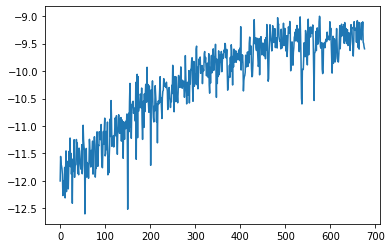

In [6]:
plt.plot(reward_records_)

In [7]:
import misc

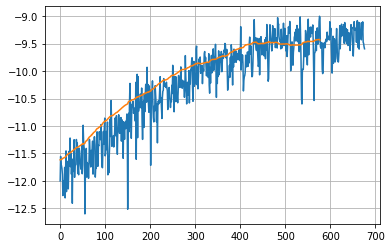

In [8]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


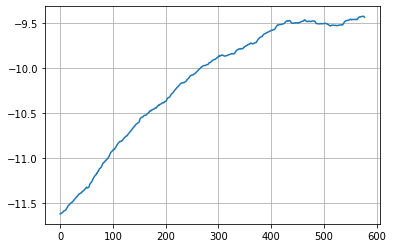

In [9]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

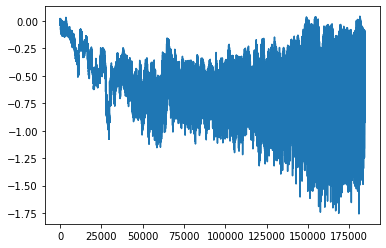

In [10]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

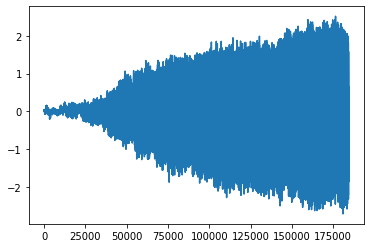

In [11]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

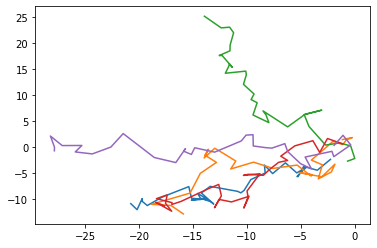

In [12]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [13]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')

INFO:tensorflow:Assets written to: actor_model_vanilla_det_singleImg_Adv/assets
